Imports

In [160]:
import math
import datetime
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ipywidgets import HBox, VBox
from tabulate import tabulate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
import scipy.stats as stats


# Matplotlib style
plt.style.use('fivethirtyeight')
# Ignoring some warnings
warnings.filterwarnings('ignore')

1. Data Loading & Initial Analysis

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Apple │         1.80         │          8.23          │         28.51         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


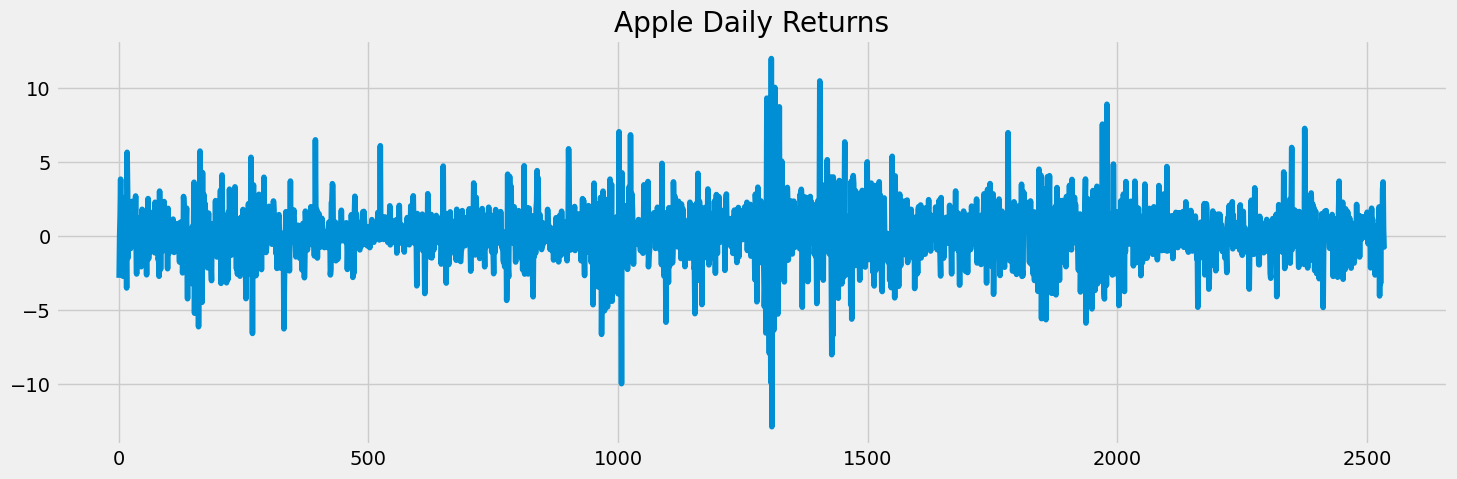

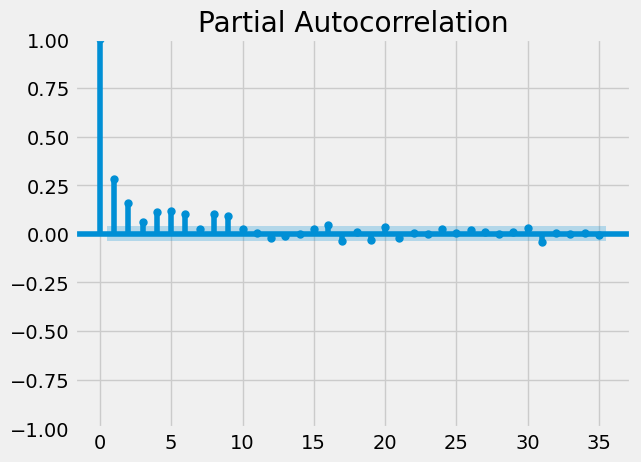

In [ ]:
#load data, calculate returns, and drop 0 returns
raw_data = pd.read_csv("AAPL1.csv")
returns = 100 * raw_data.close.pct_change().dropna()
returns = returns.drop(returns[returns == 0].index)


# Plot Cumulative Returns
close_prices = pd.DataFrame(raw_data["close"])
cum_rets = close_prices / close_prices.iloc[0,:]
fig = px.line(cum_rets.iloc[:,:], width=1000, height=500)
fig.update_layout(title_text='Cumulative Return of Apple Stock')
fig.show()

# Volatility Stats
daily_volatility = returns.std()
monthly_volatility = math.sqrt(21) * daily_volatility
annual_volatility = math.sqrt(252) * daily_volatility
print(tabulate([['Apple', daily_volatility, monthly_volatility, annual_volatility]],
               headers=['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],
               tablefmt='fancy_grid', stralign='center', numalign='center', floatfmt=".2f"))

# Plot Daily Returns
returns.plot(figsize=(16,5), title='Apple Daily Returns')
plt.show()

# Distribution Plot
return_dist_plot = ff.create_distplot([returns.values.reshape(-1)], group_labels=[' '])
return_dist_plot.update_layout(showlegend=False, title_text='Distribution of Daily Apple Returns', width=1000, height=500)
return_dist_plot.show()

# PACF Plot
plot_pacf(returns**2, method="yw")
plt.show()


2. GARCH Modeling

Starting GARCH Rolling Forecast for last 634 days...


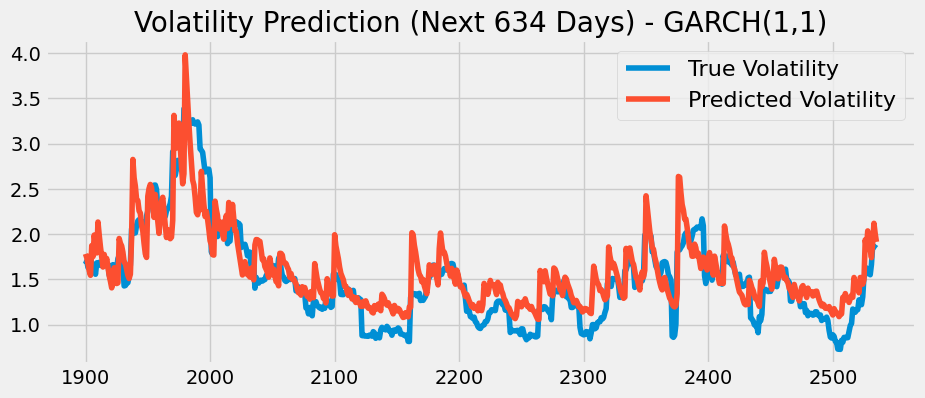

In [162]:


# Define a GARCH model (1,1)
model = arch_model(returns, dist="ged", vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')
model_fit.summary()

# Full Series GARCH (4,4) for Comparison
full_serie_garch = arch_model(returns, dist="ged", vol='GARCH', p=1, q=1)
model_fit_full_serie = full_serie_garch.fit(disp='off')

# Rolling Volatility (Target)
rolling_vol = abs(returns.rolling(window=22, min_periods=22).std().dropna())

# Plot GARCH vs Rolling
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_serie.conditional_volatility), rolling_vol.dropna()], axis=1).dropna()
garch_and_rolling_std_plot = px.line(garch_and_rolling_std, title='GARCH vs Rolling Volatility (TRAIN)', width=1000, height=500)
garch_and_rolling_std_plot.show()

# Rolling Forecast Loop
test_size = 634
rolling_predictions = []

print(f"Starting GARCH Rolling Forecast for last {test_size} days...")
for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, dist="ged", vol='GARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=returns.dropna().index[-test_size:])

# Plot GARCH Predictions
plt.figure(figsize=(10,4))
true, = plt.plot((rolling_vol)[-test_size:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction (Next 634 Days) - GARCH(1,1)', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)
plt.show()

3. XGBoost Data Preparation (Upgraded: Parkinson + Garman-Klass)

In [ ]:

# Read data again to capture all OHLC columns
raw_data_for_ml = pd.read_csv("AAPL1.csv")
df_ml = raw_data_for_ml[["date", "close", "high", "low", "open"]].copy()

# 2. Feature 1: Parkinson Volatility (High/Low)
# Captures intraday range
df_ml['Parkinson_Vol'] = np.sqrt(
    (1 / (4 * np.log(2))) * np.log(df_ml['high'] / df_ml['low'])**2
) * 100

# 3. Feature 2: Garman-Klass Volatility (Open/High/Low/Close)
# Captures intraday range AND overnight gaps
log_hl = np.log(df_ml['high'] / df_ml['low'])
log_co = np.log(df_ml['close'] / df_ml['open'])

df_ml['Garman_Klass_Vol'] = np.sqrt(
    0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2
) * 100

# 4. Calculate Daily Returns & Clean, create target and set date
df_ml["Return"] = 100 * df_ml["close"].pct_change()
df_ml = df_ml.replace([np.inf, -np.inf], np.nan).dropna()
df_ml = df_ml[df_ml["Return"] != 0]
df_ml["close"] = abs(df_ml["Return"].rolling(window=22, min_periods=22).std())
df_ml = df_ml.dropna()
df_ml["date"] = pd.to_datetime(df_ml["date"])

# Split Train/Test
test_size = 634
train_ml = df_ml.iloc[:-test_size].copy()
test_ml = df_ml.iloc[-test_size:].copy()

4. XGBoost Feature Engineering & Training

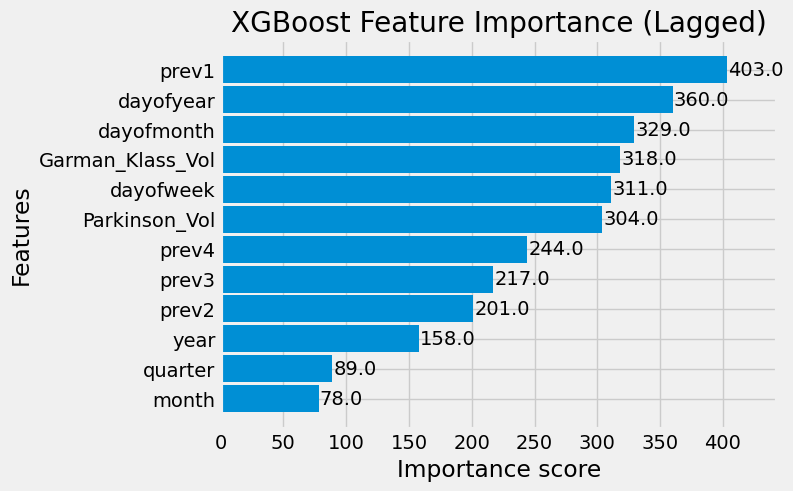

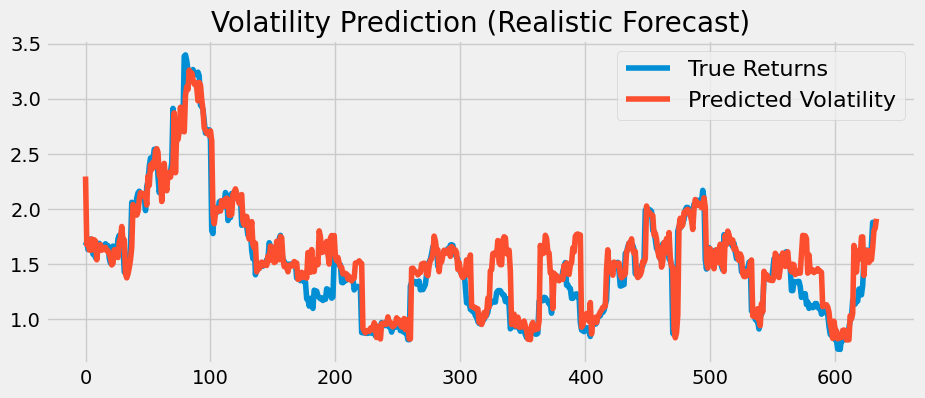

In [164]:

# UDF for extracting features from date
def create_features(df, label=None):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['dayofweek','quarter','month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

# Create base features
X_train, y_train = create_features(train_ml, label="close")
X_test, y_test = create_features(test_ml, label="close")

# Add Lag Features (Autoregression) - We use Past Data to predict Future
X_train['prev1'] = train_ml['close'].shift(1)
X_test['prev1'] = test_ml['close'].shift(1)
X_train['prev2'] = train_ml['close'].shift(2)
X_test['prev2'] = test_ml['close'].shift(2)
X_train['prev3'] = train_ml['close'].shift(3)
X_test['prev3'] = test_ml['close'].shift(3)
X_train['prev4'] = train_ml['close'].shift(4)
X_test['prev4'] = test_ml['close'].shift(4)


X_train['Parkinson_Vol'] = train_ml['Parkinson_Vol'].shift(1)
X_test['Parkinson_Vol'] = test_ml['Parkinson_Vol'].shift(1)

if 'Garman_Klass_Vol' in train_ml.columns:
    X_train['Garman_Klass_Vol'] = train_ml['Garman_Klass_Vol'].shift(1)
    X_test['Garman_Klass_Vol'] = test_ml['Garman_Klass_Vol'].shift(1)

# Fit XGBoost Model (Standard)
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

# Plot Feature Importance
_ = plot_importance(reg, height=0.9, title='XGBoost Feature Importance (Lagged)')
plt.show()

# Predictions
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

# Plot Test Predictions
plt.figure(figsize=(10,4))
true, = plt.plot(test_ml["close"].values)
preds, = plt.plot(test_ml['Prediction'].values)
plt.title('Volatility Prediction (Realistic Forecast)', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)
plt.show()

In [165]:
print(f"--- Data Split Information ---")
print(f"Training Data: {len(train_ml)} days")
print(f"From: {train_ml['date'].min().date()} to {train_ml['date'].max().date()}")
print(f"-"*30)
print(f"Testing Data:  {len(test_ml)} days")
print(f"From: {test_ml['date'].min().date()} to {test_ml['date'].max().date()}")

--- Data Split Information ---
Training Data: 1874 days
From: 2015-02-04 to 2022-07-20
------------------------------
Testing Data:  634 days
From: 2022-07-21 to 2025-01-31


5. Performance Metrics (RMSE / MAPE)

In [166]:

# Metrics for GARCH
mse_garch_full = mean_squared_error(garch_and_rolling_std["close"], garch_and_rolling_std["cond_vol"])
RMSE_Serie = np.sqrt(mse_garch_full)
MAPE_Serie = mean_absolute_percentage_error(garch_and_rolling_std["close"], garch_and_rolling_std["cond_vol"])
mse_garch_pred = mean_squared_error(rolling_vol[-test_size:], rolling_predictions)
RMSE = np.sqrt(mse_garch_pred)
MAPE = mean_absolute_percentage_error(rolling_vol[-test_size:], rolling_predictions)

# Metrics for XGBoost
MSE_Serie_XG = mean_squared_error(train_ml["close"], train_ml["Predictions"])
RMSE_Serie_XG = np.sqrt(MSE_Serie_XG)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["close"], train_ml["Predictions"])
MSE_XG = mean_squared_error(test_ml["close"], test_ml['Prediction'])
RMSE_XG = np.sqrt(MSE_XG)
MAPE_XG = mean_absolute_percentage_error(test_ml["close"], test_ml['Prediction'])

print(tabulate([['MAPE', round(MAPE_Serie*100,2), round(MAPE_Serie_XG*100,2), round(MAPE*100,2), round(MAPE_XG*100,2)]],
               headers=['GARCH TRAIN %', 'XGBOOST TRAIN %', 'GARCH PREDICTIONS %', 'XGBOOST PREDICTIONS %'],
               tablefmt='fancy_grid', stralign='center', numalign='center', floatfmt=".2f"))

╒══════╤═════════════════╤═══════════════════╤═══════════════════════╤═════════════════════════╕
│      │  GARCH TRAIN %  │  XGBOOST TRAIN %  │  GARCH PREDICTIONS %  │  XGBOOST PREDICTIONS %  │
╞══════╪═════════════════╪═══════════════════╪═══════════════════════╪═════════════════════════╡
│ MAPE │      16.75      │       2.99        │         15.57         │          9.50           │
╘══════╧═════════════════╧═══════════════════╧═══════════════════════╧═════════════════════════╛


6. Risk Estimation: Value at Risk (VaR)

Calculating VaR at 95.0% confidence level
Using Normal Distribution -> Multiplier (Z-Score): 1.645

--- Risk Estimation Results (Test Period) ---
Total Days: 634
Target Breaches (5%): 32
------------------------------
GARCH Breaches:   26 (4.10%)
XGBoost Breaches: 26 (4.10%)


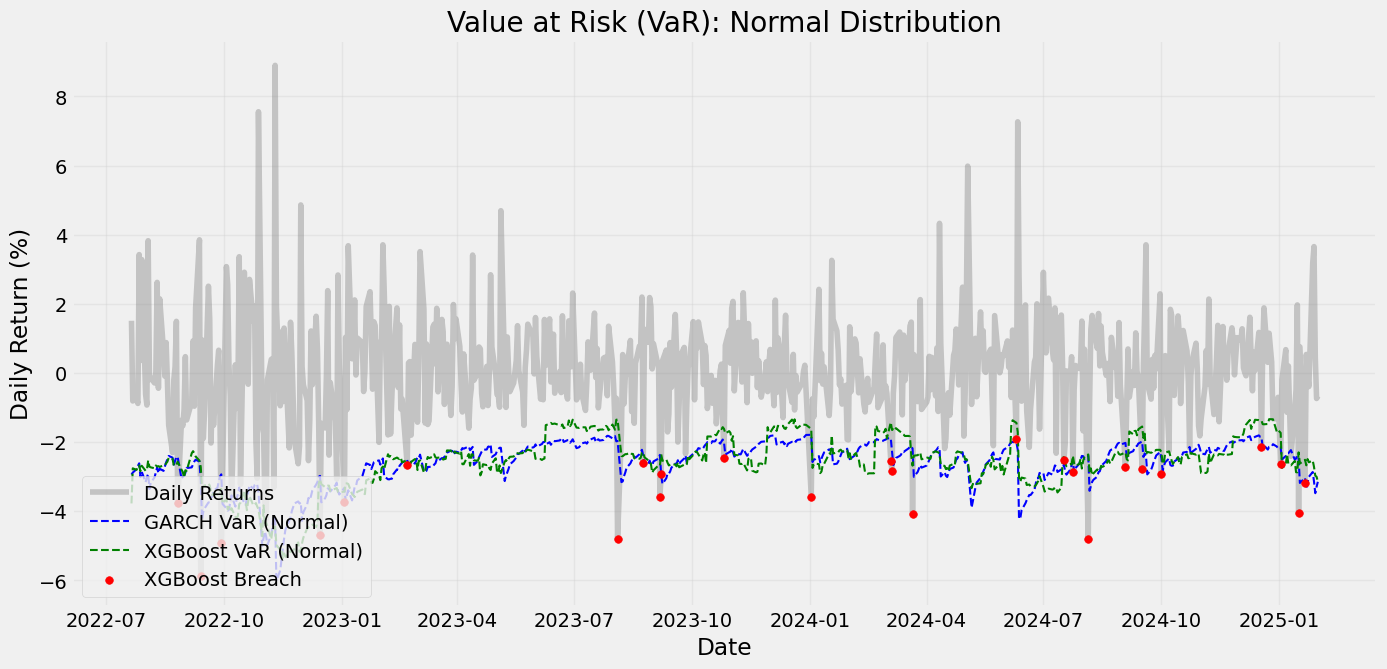

In [167]:

# 1. Setup Parameters
confidence_level = 0.95
alpha = 1 - confidence_level
z_score = stats.norm.ppf(confidence_level)
print(f"Calculating VaR at {confidence_level*100}% confidence level")
print(f"Using Normal Distribution -> Multiplier (Z-Score): {z_score:.3f}")

# 2. Prepare Risk DataFrame
risk_df = test_ml.copy()
risk_df = risk_df.rename(columns={'Prediction': 'XGBoost_Vol'})
risk_df['GARCH_Vol'] = garch_and_rolling_std.loc[risk_df.index, 'cond_vol']
risk_df['Actual_Return'] = returns.loc[risk_df.index]

# 3. Calculate VaR (Using Z-Score)
risk_df['GARCH_VaR_95'] = -1 * risk_df['GARCH_Vol'] * z_score
risk_df['XGBoost_VaR_95'] = -1 * risk_df['XGBoost_Vol'] * z_score

# 4. Identify Breaches
garch_breaches = risk_df[risk_df['Actual_Return'] < risk_df['GARCH_VaR_95']]
xgboost_breaches = risk_df[risk_df['Actual_Return'] < risk_df['XGBoost_VaR_95']]

print(f"\n--- Risk Estimation Results (Test Period) ---")
print(f"Total Days: {len(risk_df)}")
print(f"Target Breaches (5%): {len(risk_df) * alpha:.0f}")
print(f"-"*30)
print(f"GARCH Breaches:   {len(garch_breaches)} ({len(garch_breaches)/len(risk_df):.2%})")
print(f"XGBoost Breaches: {len(xgboost_breaches)} ({len(xgboost_breaches)/len(risk_df):.2%})")

# 5. Visualization (With Date on X-Axis)
plot_df = risk_df.copy()
plot_df['date'] = pd.to_datetime(plot_df['date'])
plot_df.set_index('date', inplace=True) 
plot_xg_breaches = plot_df[plot_df['Actual_Return'] < plot_df['XGBoost_VaR_95']]
plt.figure(figsize=(15, 7))
plt.plot(plot_df.index, plot_df['Actual_Return'], color='grey', alpha=0.4, label='Daily Returns')
plt.plot(plot_df.index, plot_df['GARCH_VaR_95'], color='blue', linestyle='--', linewidth=1.5, label='GARCH VaR (Normal)')
plt.plot(plot_df.index, plot_df['XGBoost_VaR_95'], color='green', linestyle='--', linewidth=1.5, label='XGBoost VaR (Normal)')
plt.scatter(plot_xg_breaches.index, plot_xg_breaches['Actual_Return'], color='red', s=30, zorder=5, label='XGBoost Breach')
plt.title('Value at Risk (VaR): Normal Distribution')
plt.ylabel('Daily Return (%)')
plt.xlabel('Date')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()

7. Risk Estimation: Expected Shortfall (ES)

--- Expected Shortfall (ES) Analysis ---
GARCH ES (Avg Loss on Breach Days):   -3.40%
XGBoost ES (Avg Loss on Breach Days): -3.37%


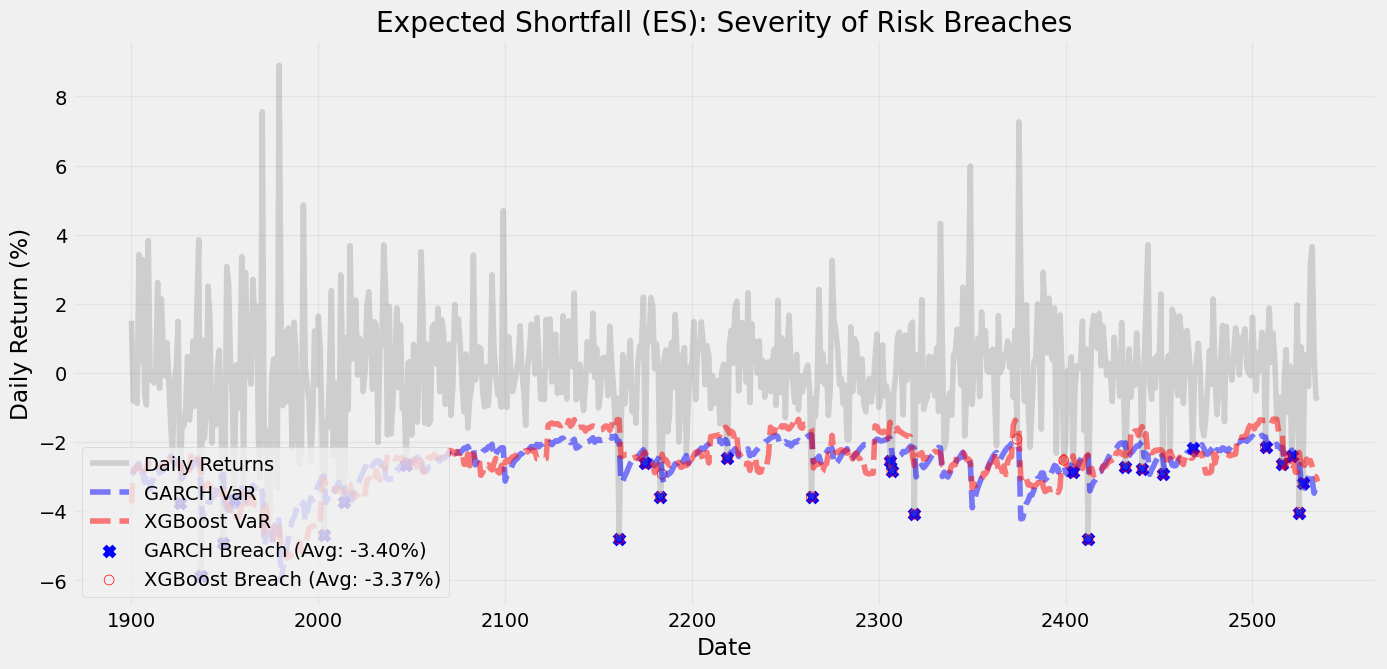

In [168]:

# Calculate ES
garch_es = garch_breaches['Actual_Return'].mean()
xgboost_es = xgboost_breaches['Actual_Return'].mean()

print(f"--- Expected Shortfall (ES) Analysis ---")
print(f"GARCH ES (Avg Loss on Breach Days):   {garch_es:.2f}%")
print(f"XGBoost ES (Avg Loss on Breach Days): {xgboost_es:.2f}%")

# Visualization: ES Severity
plt.figure(figsize=(15, 7))
plt.plot(risk_df.index, risk_df['Actual_Return'], color='grey', alpha=0.3, label='Daily Returns')
plt.plot(risk_df.index, risk_df['GARCH_VaR_95'], color='blue', linestyle='--', alpha=0.5, label='GARCH VaR')
plt.plot(risk_df.index, risk_df['XGBoost_VaR_95'], color='red', linestyle='--', alpha=0.5, label='XGBoost VaR')
plt.scatter(garch_breaches.index, garch_breaches['Actual_Return'], color='blue', s=50, marker='x', label=f'GARCH Breach (Avg: {garch_es:.2f}%)')
plt.scatter(xgboost_breaches.index, xgboost_breaches['Actual_Return'], color='red', s=50, marker='o', facecolors='none', edgecolors='red', label=f'XGBoost Breach (Avg: {xgboost_es:.2f}%)')
plt.title('Expected Shortfall (ES): Severity of Risk Breaches')
plt.ylabel('Daily Return (%)')
plt.xlabel('Date')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()

9. Trading Strategy: Volatility Targeting 

--- Weight Diagnostics ---
Max Weight: 1.50
Min Weight: 0.39
Avg Weight: 0.87
Days with < 50% Exposure: 32
------------------------------
Max Drawdown (Buy & Hold): -28.26%
Max Drawdown (Vol-Target): -19.43%

SUCCESS: The Strategy protected capital better during the worst crash.

--- Final Strategy Performance ---
Buy & Hold Return:     56.30%
Vol-Target Return:     44.72%
Buy & Hold Volatility: 25.23%
Vol-Target Volatility: 21.13% (Target: 20%)
Sharpe Improvement:    2.12 vs 2.23 (B&H)


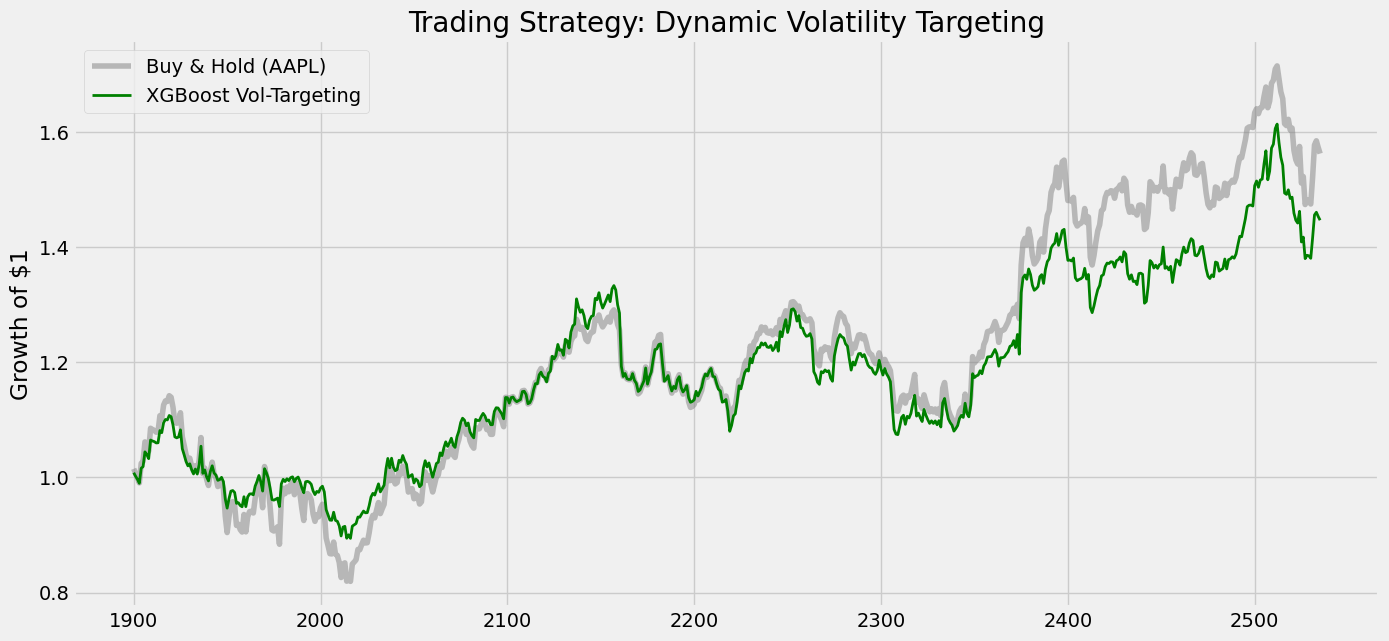

In [169]:

#  Define Strategy Parameters
target_vol_ann = 0.20  # Target 20% annual volatility
target_vol_daily = target_vol_ann / np.sqrt(252)
leverage_cap = 1.5     # Max leverage (1.5x)
strategy_df = test_ml.copy()
strategy_df['Forecast_Vol_Pct'] = strategy_df['Prediction'] 
strategy_df['Forecast_Vol_Decimal'] = strategy_df['Forecast_Vol_Pct'] / 100
strategy_df['Weight'] = (target_vol_daily / strategy_df['Forecast_Vol_Decimal'])
strategy_df['Weight'] = strategy_df['Weight'].clip(upper=leverage_cap, lower=0.0)

#  Calculate Returns
strategy_df['Real_Daily_Return_Pct'] = returns.loc[strategy_df.index]
strategy_df['Real_Daily_Return_Decimal'] = strategy_df['Real_Daily_Return_Pct'] / 100
strategy_df['Strategy_Return'] = strategy_df['Weight'] * strategy_df['Real_Daily_Return_Decimal']
strategy_df['BuyHold_Return'] = strategy_df['Real_Daily_Return_Decimal']

print("--- Weight Diagnostics ---")
print(f"Max Weight: {strategy_df['Weight'].max():.2f}")
print(f"Min Weight: {strategy_df['Weight'].min():.2f}")
print(f"Avg Weight: {strategy_df['Weight'].mean():.2f}")
print(f"Days with < 50% Exposure: {len(strategy_df[strategy_df['Weight'] < 0.5])}")
print("-" * 30)

strategy_df['Strategy_Equity'] = (1 + strategy_df['Strategy_Return']).cumprod()
strategy_df['BuyHold_Equity'] = (1 + strategy_df['BuyHold_Return']).cumprod()

#  Performance Metrics
strat_ret_total = strategy_df['Strategy_Equity'].iloc[-1] - 1
bh_ret_total = strategy_df['BuyHold_Equity'].iloc[-1] - 1

strat_vol_ann = strategy_df['Strategy_Return'].std() * np.sqrt(252)
bh_vol_ann = strategy_df['BuyHold_Return'].std() * np.sqrt(252)

def calculate_max_drawdown(equity_curve):
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    return drawdown.min()

strat_dd = calculate_max_drawdown(strategy_df['Strategy_Equity'])
bh_dd = calculate_max_drawdown(strategy_df['BuyHold_Equity'])

print(f"Max Drawdown (Buy & Hold): {bh_dd:.2%}")
print(f"Max Drawdown (Vol-Target): {strat_dd:.2%}")

if strat_dd > bh_dd:
    print("\nSUCCESS: The Strategy protected capital better during the worst crash.")

sharpe_strat = strat_ret_total / strat_vol_ann
sharpe_bh = bh_ret_total / bh_vol_ann


print(f"\n--- Final Strategy Performance ---")
print(f"Buy & Hold Return:     {bh_ret_total:.2%}")
print(f"Vol-Target Return:     {strat_ret_total:.2%}")
print(f"Buy & Hold Volatility: {bh_vol_ann:.2%}")
print(f"Vol-Target Volatility: {strat_vol_ann:.2%} (Target: {target_vol_ann:.0%})")
print(f"Sharpe Improvement:    {sharpe_strat:.2f} vs {sharpe_bh:.2f} (B&H)")

# Plot
plt.figure(figsize=(15, 7))
plt.plot(strategy_df.index, strategy_df['BuyHold_Equity'], label='Buy & Hold (AAPL)', color='grey', alpha=0.5)
plt.plot(strategy_df.index, strategy_df['Strategy_Equity'], label='XGBoost Vol-Targeting', color='green', linewidth=2)
plt.title('Trading Strategy: Dynamic Volatility Targeting')
plt.ylabel('Growth of $1')
plt.legend()
plt.show()

10. Ensemble Model


--- Model Comparison (RMSE) ---
GARCH RMSE:    0.2639
XGBoost RMSE:  0.1967
Ensemble RMSE: 0.1918

SUCCESS: The Ensemble model outperformed both individual models.


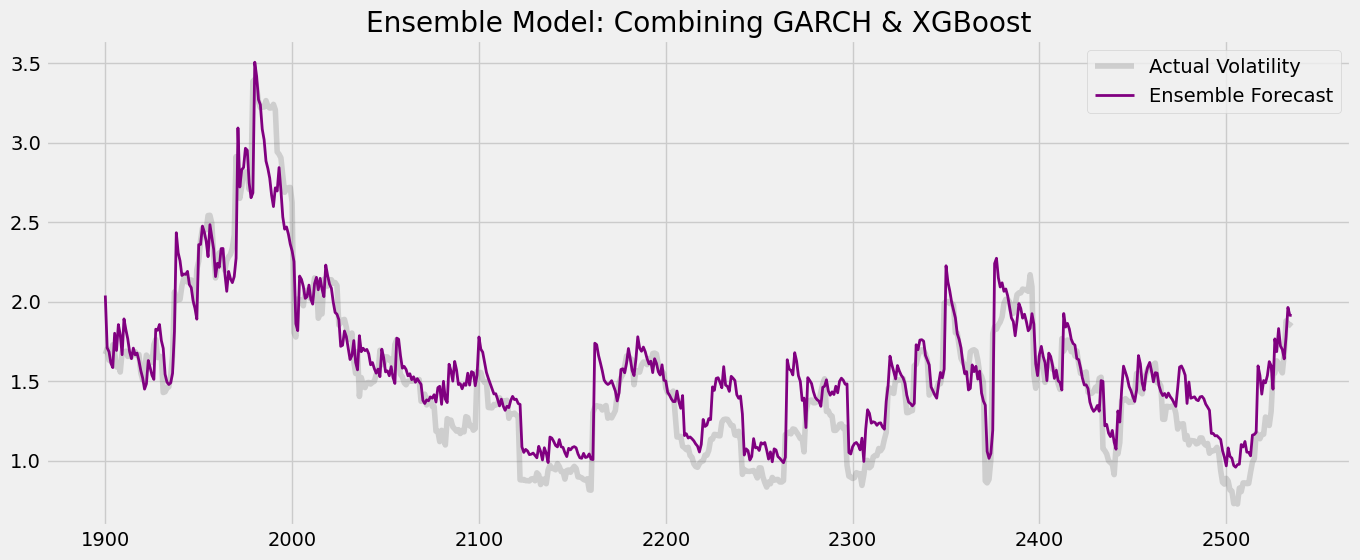

In [170]:

# 1. Create the Ensemble
ensemble_df = test_ml.copy()
ensemble_df['GARCH_Pred'] = rolling_predictions.values # From Section 2
ensemble_df['XGBoost_Pred'] = ensemble_df['Prediction'] # From Section 4
ensemble_df['Ensemble_Vol'] = (ensemble_df['GARCH_Pred'] + ensemble_df['XGBoost_Pred']) / 2

# 2. Compare Performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
true_vol = ensemble_df['close']
rmse_garch = np.sqrt(mean_squared_error(true_vol, ensemble_df['GARCH_Pred']))
rmse_xgb = np.sqrt(mean_squared_error(true_vol, ensemble_df['XGBoost_Pred']))
rmse_ens = np.sqrt(mean_squared_error(true_vol, ensemble_df['Ensemble_Vol']))
print(f"--- Model Comparison (RMSE) ---")
print(f"GARCH RMSE:    {rmse_garch:.4f}")
print(f"XGBoost RMSE:  {rmse_xgb:.4f}")
print(f"Ensemble RMSE: {rmse_ens:.4f}")
best_model = min(rmse_garch, rmse_xgb, rmse_ens)
if best_model == rmse_ens:
    print("\nSUCCESS: The Ensemble model outperformed both individual models.")
else:
    print("\nNOTE: The Ensemble did not improve performance this time.")

# 3. Plot the Ensemble
plt.figure(figsize=(15, 6))
plt.plot(true_vol.index, true_vol, color='grey', alpha=0.3, label='Actual Volatility')
plt.plot(ensemble_df.index, ensemble_df['Ensemble_Vol'], color='purple', linewidth=2, label='Ensemble Forecast')
plt.title('Ensemble Model: Combining GARCH & XGBoost')
plt.legend()
plt.show()